### Instalando librerias

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.utils import to_categotical
import keras

from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

ImportError: cannot import name 'to_categotical' from 'keras.utils' (/home/miguel/anaconda3/envs/EGC/lib/python3.8/site-packages/keras/utils/__init__.py)

In [9]:
tf.__version__

'2.2.0'

### Lectura de datos csv

In [3]:
train_df=pd.read_csv('../data/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/mitbih_test.csv',header=None)

In [4]:
train_df.shape

(87554, 188)

In [5]:
test_df.shape

(21892, 188)

### Preprocesamiento

In [6]:
from sklearn.utils import resample

df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

### Shaping

In [7]:
target_train = train_df[187]
target_test = test_df[187]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

NameError: name 'to_categorical' is not defined

In [ ]:
len(y_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# print('Antes del reshaping: ', X_train.shape)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print('Despues del reshaping: ')
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

### Modelo

In [26]:
model = Sequential()

model.add(Convolution1D(32, (6), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Flatten())

model.add(Dense(5, activation='softmax', name='main_output'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='conv_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/40
391/391 [==============================] - 51s 131ms/step - loss: 0.3786 - accuracy: 0.8670 - val_loss: 2.5966 - val_accuracy: 0.0954
Epoch 2/40
391/391 [==============================] - 52s 134ms/step - loss: 0.1692 - accuracy: 0.9429 - val_loss: 0.2588 - val_accuracy: 0.9119
Epoch 3/40
391/391 [==============================] - 54s 137ms/step - loss: 0.1230 - accuracy: 0.9594 - val_loss: 0.1872 - val_accuracy: 0.9346
Epoch 4/40
391/391 [==============================] - 56s 144ms/step - loss: 0.0941 - accuracy: 0.9694 - val_loss: 0.1468 - val_accuracy: 0.9534
Epoch 5/40
391/391 [==============================] - 53s 136ms/step - loss: 0.0770 - accuracy: 0.9755 - val_loss: 0.2245 - val_accuracy: 0.9206
Epoch 6/40
391/391 [==============================] - 53s 136ms/step - loss: 0.0652 - accuracy: 0.9798 - val_loss: 0.1272 - val_accuracy: 0.9610
Epoch 7/40
391/391 [==============================] - 52s 132ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.1482 - val_ac

### Ploting results

In [27]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 96.53%


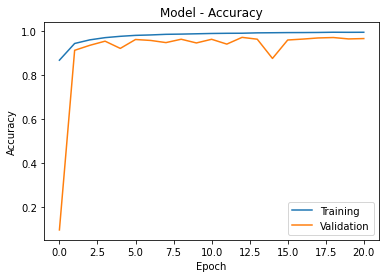

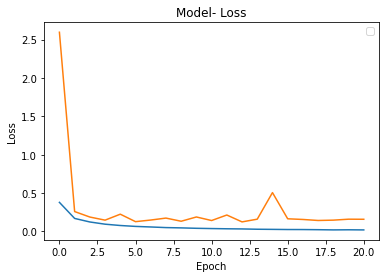

In [28]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [29]:
# model_name = 'best_model.h5'
# model = keras.models.load_model(f'../model/{model_name}')

y_pred = model.predict(X_test)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 181, 32)           224       
_________________________________________________________________
batch_normalization_9 (Batch (None, 181, 32)           128       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 91, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 89, 32)            3104      
_________________________________________________________________
batch_normalization_10 (Batc (None, 89, 32)            128       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 43, 32)           

In [30]:
def get_max_index_list(x):
    return [np.where(i == np.amax(i))[0][0] for i in x]

In [31]:
y_test_list = get_max_index_list(y_test)
y_pred_list = get_max_index_list(y_pred)

print("Precision", precision_score(y_test_list, y_pred_list, average='macro'))
print("Recall", recall_score(y_test_list, y_pred_list, average='macro'))
print("f1_score", f1_score(y_test_list, y_pred_list, average='macro'))

Precision 0.8221866904486284
Recall 0.8966201837865228
f1_score 0.8555680337542807


### Confusion matrix

Normalized confusion matrix


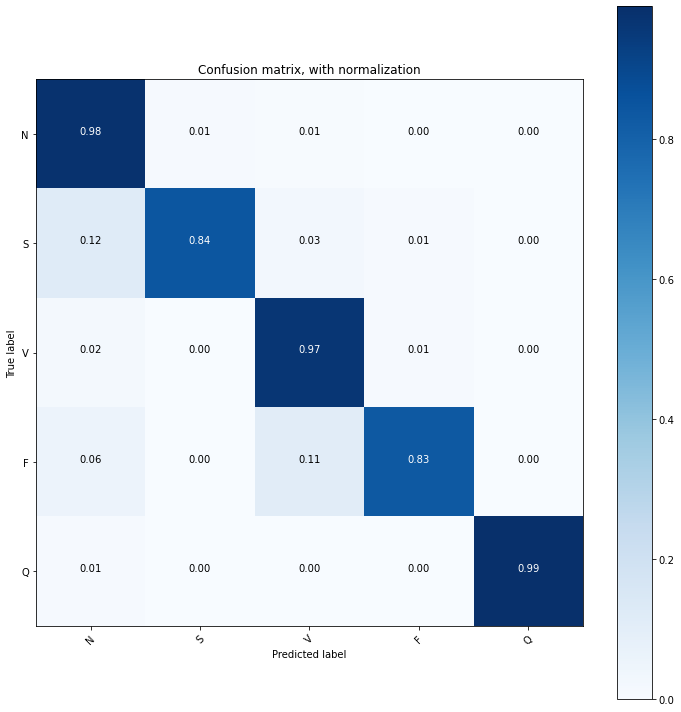

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()